# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne.
It is licensed for the sole purpose of your assessment in COMP90051.
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project.
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

The base `SVM` class below defines a common interface for a support vector machine.
Your implementations below for each part of the project should inherit from this class. Feel free to add to this class if you need.

In [6]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""

    def __init__(self) -> None:
        pass

    @abstractmethod
    def fit(self, X, y) -> None:
        """Fit the model with the given training data.

        Parameters
        ----------
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances.
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """

    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances.

        -------
        Return
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """

    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances.
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """

        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc

    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model.
        This function is adapted from
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances.
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)

        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"

        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out

        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### Binary classification data
First, we will generate some toy binary classification data, re-using the code from workshop 4. This will be used for parts 1-3, and the start of part 4.

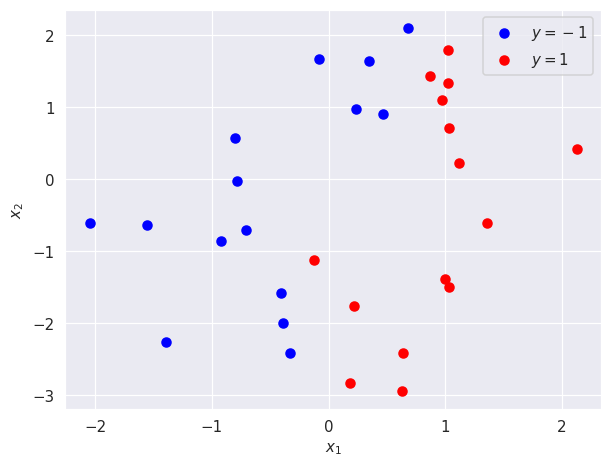

In [7]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Part 1: Primal soft-margin SVM

In [8]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """

    def __init__(self, eta, lambda0)-> None:
        super().__init__()
        ## your code here
        self.eta = eta
        self.lambda0 = lambda0
        ### end of your code ###

    def fit(self, X, y, iterations = 100)-> None:
        super().fit(X=X,y=y)
        ## your code here ###
        assert X.shape[0] == y.shape[0], "Mismatch in x and y samples"
        assert not np.isnan(X).any(), "X contains Not a number values"
        assert not np.isnan(y).any(), "y contains Not a number values"
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        for _ in tqdm.tqdm(range(iterations)):
          for i in range(0,len(y)):
            X_sample, y_sample = X[i], y[i]
            yy_hat = y_sample*(np.dot(self.weights,X_sample)+self.bias)
            # print(yy_hat)
            if yy_hat >= 1:
                grad_w = self.lambda0 * self.weights
                grad_b = 0
            else:
                grad_w = self.lambda0 * self.weights - y_sample * X_sample
                grad_b = -y_sample

            self.weights -= self.eta * grad_w
            self.bias -= self.eta * grad_b
        #reference - As provided in the assignment.
        ### end of your code ###


    def predict(self, test_X) -> int:
        super().predict(test_X = test_X)
        ## your code here ###
        predictions = np.sign(np.dot(test_X, self.weights) + self.bias)
        return predictions
        ### end of your code ###

100%|██████████| 100/100 [00:00<00:00, 1730.12it/s]


Accuracy is 0.9


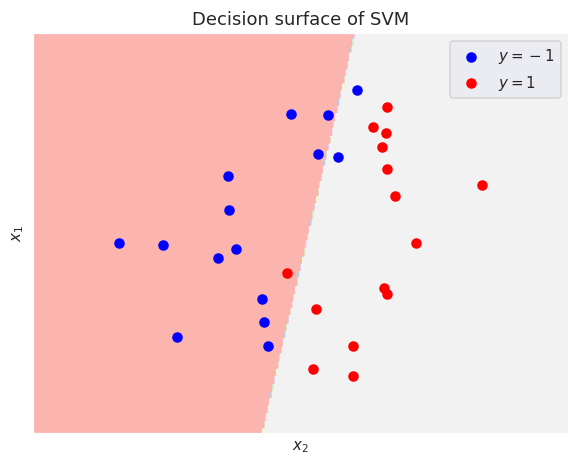

In [9]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
psvm.visualize(X,y)

### Tuning lambda value

100%|██████████| 100/100 [00:00<00:00, 1885.93it/s]


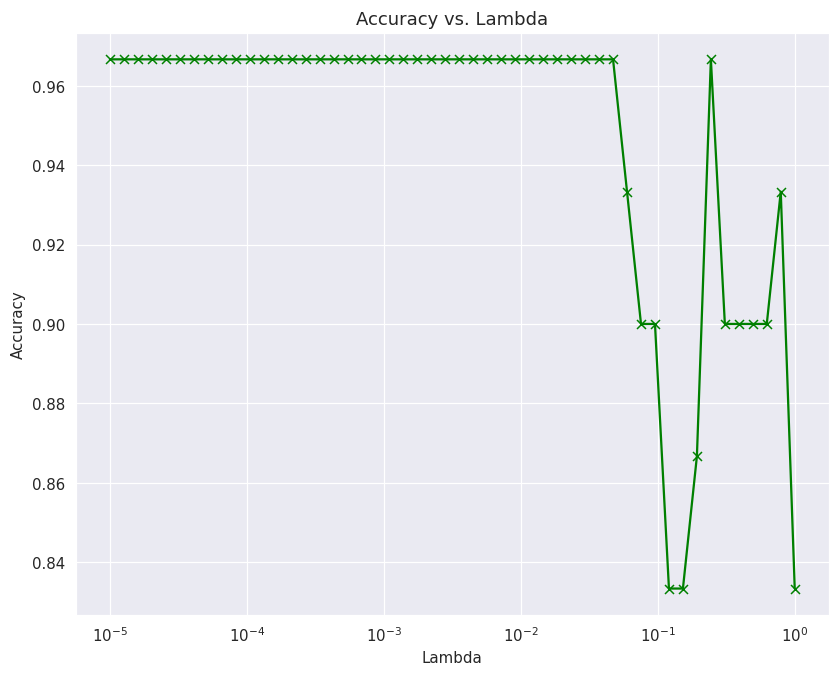

The best lambda value is: 0.04714866363457394 with accuracy: 0.9667


In [10]:
# Use this cell for experimentation 1.b
lambdas = np.logspace(-5, 0, 50)
accs = []

#Training the primalSVM for all the lambda values
for lambda1 in lambdas:
    psvm = PrimalSVM(eta=0.1, lambda0=lambda1)
    psvm.fit(X, y, iterations=100)
    acc = psvm.evaluate(X, y)
    accs.append(acc)

# print(accs)

#A semilogx plot is preferred to a normal plot here
plt.figure(figsize=(9,7))
plt.semilogx(lambdas, accs, marker='x',color="g")

plt.xlabel('Lambda')
plt.ylabel('Accuracy')

plt.title('Accuracy vs. Lambda')
plt.show()

for i in range(1,len(accs)):
  if(accs[i] < accs[i-1]):
    index_before_drop = i-1
    break

best_lambda = lambdas[index_before_drop]
print(f"The best lambda value is: {best_lambda} with accuracy: {accs[index_before_drop]:.4f}")

## Part 2: Dual soft-margin SVM

In [11]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """

    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel

        ## your code here ###
        self.eta = eta
        self.C = C
        ### end of your code ###

    def fit(self, X, y, iterations = 100):

        super().fit(X=X,y=y)
        self.X = X
        self.y = y

        ### your code here ###
        #self.alphas = ... # lagrange multipliers (sometimes denoted lambda), you should initialize with 0s
        self.alphas = np.zeros(X.shape[0])

        for _ in tqdm.tqdm(range(iterations)):
            for i in range(len(y)):

              x_sample, y_sample = X[i], y[i]
              kernel_output = self.kernel(X, x_sample)
              # print(kernel_output)
              self.alphas[i]+=self.eta*(1-y_sample * np.sum(self.alphas * self.y * kernel_output))
              #Reference - https://www.cambridge.org/core/services/aop-cambridge-core/content/view/6875C27F9EC2BF3F5EF1BB74296AF871/9780511801389c7_p125-148_CBO.pdf/implementation-techniques.pdf

              if(self.alphas[i] < 0):
                self.alphas[i] = 0

              elif(self.alphas[i]>self.C):
                self.alphas[i] = self.C

        ### end of your code ###
        self.bias = self.get_bias()
        return

    def predict(self, test_X):
        super().predict(test_X =test_X)
        ### your code here ###
        kernel_outputs = self.kernel(self.X, test_X)
        predictions = np.sign(np.sum(self.alphas[:, None] * self.y[:, None] * kernel_outputs, axis=0) + self.bias)
        return predictions
        ### end of your code ###

    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        ### your code here ###
        return np.sum(self.alphas[:,None] * self.y[:,None] * self.X, axis=0)
        ### end of your code ###

    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """
        ### your code here ###
        support_vector_indices = (self.alphas > 0) & (self.alphas < self.C)
        sv_X = self.X[support_vector_indices]
        sv_y = self.y[support_vector_indices]
        sv_alphas = self.alphas[support_vector_indices]
        kernel_output = self.kernel(X, sv_X)
        biases = sv_y - np.sum(self.alphas[:, None] * self.y[:, None] * kernel_output, axis=0)
        bias = np.mean(biases)
        return bias
        ### end of your code ###

100%|██████████| 100/100 [00:00<00:00, 2918.69it/s]


Accuracy is 0.9667


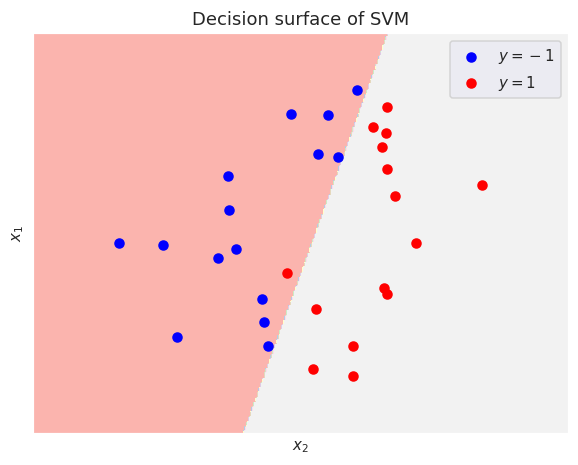

In [12]:
dsvm = DualSVM(eta = 0.1, C = 100)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

### Tuning C value

100%|██████████| 100/100 [00:00<00:00, 1920.40it/s]


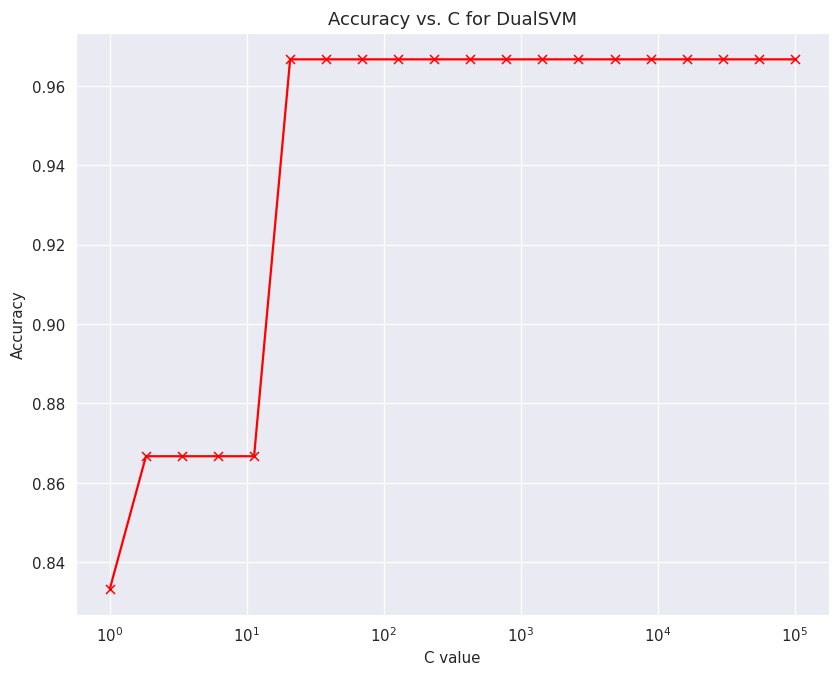

Best C value for DualSVM is 20.69138081114789 with accuracy 0.9667


In [13]:
# Use this cell here for experimentation 2.a
C_val = np.logspace(0,5,20)
#The values for C and lambda will differ in the np.logspace
accuracies = []

for C in C_val:
    dsvm = DualSVM(eta=0.1, C=C)
    dsvm.fit(X, y, iterations=100)
    acc = dsvm.evaluate(X, y)
    accuracies.append(acc)

#Once again a semilogx plot is preferred to a normal plot here
plt.figure(figsize=(9,7))
plt.semilogx(C_val, accuracies, marker='x', color='r')

plt.xlabel('C value')
plt.ylabel('Accuracy')

plt.title('Accuracy vs. C for DualSVM')

plt.show()

best_C = C_val[np.argmax(accuracies)]
print(f"Best C value for DualSVM is {best_C} with accuracy {max(accuracies):.4f}")

### Compare weights between primal and dual

In [14]:
# Use this cell here for experimentation 2.b
dsvm = DualSVM(eta = 0.1,C = 20.691)
dsvm.fit(X,y, iterations = 100)
print(dsvm.primal_weights())

lambda_equiv = 1 / best_C

# print(lambda_equiv, best_lambda)
# 0.048329302385717546 0.04714866363457394
#We can observe that the best lambda value and 1/C are almost close to each other.
#In theory lambda and C are inversely proportional to each other, but here we consider 1/C instead of best_lambda

psvm = PrimalSVM(eta=0.1, lambda0=lambda_equiv)
psvm.fit(X, y, iterations=100)
primal_weights = psvm.weights
print(primal_weights)

weight_diff_norm = np.linalg.norm(primal_weights - dsvm.primal_weights())
print(weight_diff_norm)

100%|██████████| 100/100 [00:00<00:00, 1638.94it/s]


[ 1.41067863 -0.33298488]


100%|██████████| 100/100 [00:00<00:00, 1597.04it/s]

[ 2.09506257 -0.23789293]
0.6909586506498612


### Identify support vectors and points where alpha=C

In [15]:
# Use this cell here for experimentation 2.c
support_vector_indices = np.where((dsvm.alphas > 0))[0]
margin_vector_indices = np.where(dsvm.alphas == dsvm.C)[0]

print("Support Vector Indices where alpha is greater than 0: ", support_vector_indices)
print("Indices where alpha is equal to C: ",margin_vector_indices)

Support Vector Indices where alpha is greater than 0:  [ 0  2  3  6  7  8  9 10 16 18 20 22 23 24 26 29]
Indices where alpha is equal to C:  []


## Part 3: Kernel

In [24]:
from numpy.linalg import norm


class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    degree: int
        Polymonial degree, for polynormial kernel. All other kernel need ignore this.
    simga: float
        Kernel coefficient for polynormial. All other kernel need ignore this.
    gamma: float
        Kernel coefficient for RBF. All other kernel need ignore this.
    c: float
        Kernel coefficient for IMQ. All other kernel need ignore this.
    """

    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.gamma = kwargs.get('gamma')
            self.kernel = self.rbf_kernel
        if kernel_type == "imq":
            self.c = kwargs.get('c')
            self.kernel = self.imq_kernel

    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)

        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        return self.kernel(u, v)

    def linear_kernel(self, u, v):
        return np.dot(u,v.T)

    def poly_kernel(self, u, v):
        ### your code here ###
        return (np.dot(u, v.T) + self.sigma) ** self.degree
        ### end of your code ###

    def rbf_kernel(self, u, v):
        ### your code here ###
        if u.ndim == 1:
            u = u[np.newaxis, :]
        if v.ndim == 1:
            v = v[np.newaxis, :]

        d_squared = np.sum(u**2, axis=1)[:,None] + np.sum(v**2, axis=1) - 2 * np.dot(u, v.T)
        return np.squeeze(np.exp(-self.gamma*d_squared))
        ### end of your code ###

    def imq_kernel(self, u, v):
        ### your code here ###
      if u.ndim == 1:
        u = u[np.newaxis, :]
      if v.ndim == 1:
        v = v[np.newaxis, :]

      # Calculate the squared Euclidean distance
      d_squared = np.sum(u**2, axis=1)[:, None] + np.sum(v**2, axis=1) - 2 * np.dot(u, v.T)

      # Compute the IMQ kernel
      return 1.0 / np.sqrt(d_squared + self.c**2)
        ### end of your code ###

### Test your kernel in the DualSVM

100%|██████████| 100/100 [00:00<00:00, 1700.33it/s]


Accuracy with Linear kernel is 0.9667


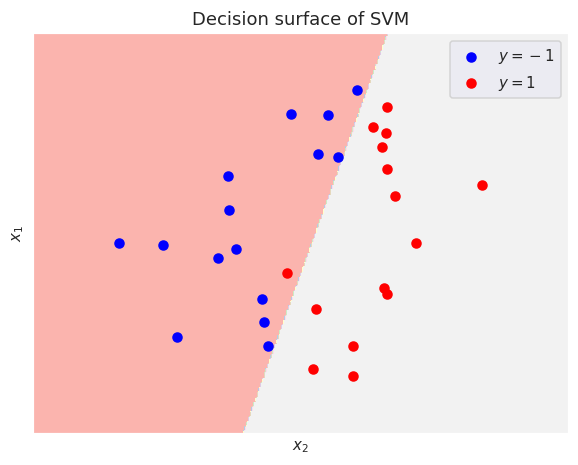

100%|██████████| 100/100 [00:00<00:00, 1169.60it/s]


Accuracy with poly kernel is 0.9333


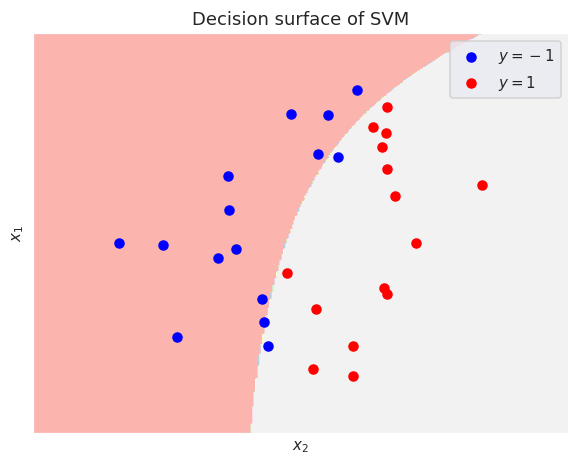

100%|██████████| 100/100 [00:00<00:00, 567.85it/s]


Accuracy with rbf kernel is 1.0


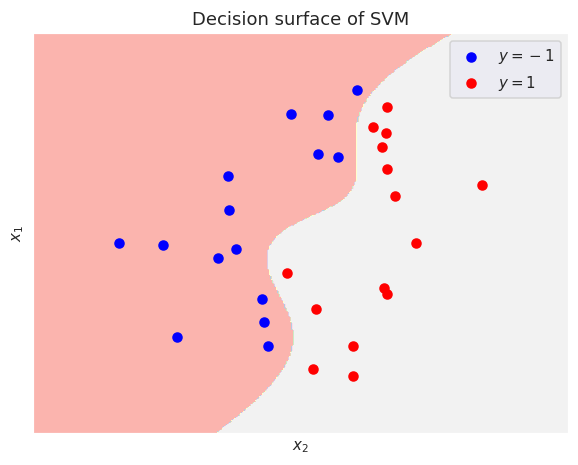

100%|██████████| 100/100 [00:00<00:00, 787.89it/s]


Accuracy with imq kernel is 0.9333


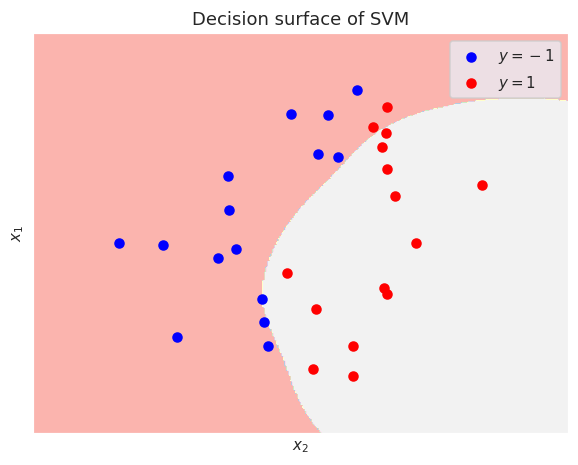

In [26]:
# Use this cell here for experimentation 3, e.g.,
svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
svm.fit(X,y, iterations = 100)
print(f"Accuracy with Linear kernel is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly',poly_degree=2,poly_offset=3))
svm.fit(X,y, iterations = 100)
print(f"Accuracy with poly kernel is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',gamma=0.5))
svm.fit(X,y, iterations = 100)
print(f"Accuracy with rbf kernel is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

svm_imq = DualSVM(eta = 0.1, C = 100, kernel = Kernel('imq', c=1))
svm_imq.fit(X, y, iterations = 100)
print(f"Accuracy with imq kernel is {round(svm_imq.evaluate(X, y), 4)}")
svm_imq.visualize(X, y)


Use this cell for your analysis for part 3.